In [5]:
import requests
import zipfile
from pathlib import Path
import random
from PIL import Image
import numpy as np
import matplotlib.pylab as plt
import os
from typing import Tuple, Dict, List
from tqdm.auto import tqdm
from timeit import default_timer as timer 


from torch.utils.data import  DataLoader
from torchvision import datasets, transforms
import torch 
import torch.nn as nn
from torch.utils.data import Dataset
from torchinfo import summary

c:\Users\Jakub Machura\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
class ImageFolderCustom(Dataset):
    
    # 2. Initialize with a targ_dir and transform (optional) parameter
    def __init__(self, targ_dir: str, transform=None) -> None:
        
        # 3. Create class attributes
        # Get all image paths
        self.paths = list(Path(targ_dir).glob("*/*.jpg")) # note: you'd have to update this if you've got .png's or .jpeg's
        # Setup transforms
        self.transform = transform
        # Create classes and class_to_idx attributes
        # print(self.paths)
        self.classes, self.class_to_idx = self.find_classes(targ_dir)

    # 4. Make function to load images
    def load_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.paths[index]
        return Image.open(image_path) 
    
    # 5. Overwrite the __len__() method (optional but recommended for subclasses of torch.utils.data.Dataset)
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.paths)
    
    # 6. Overwrite the __getitem__() method (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        "Returns one sample of data, data and label (X, y)."
        img = self.load_image(index)
        class_name  = self.paths[index].parent.name # expects path in data_folder/class_name/image.jpeg
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx # return data, label (X, y)
        else:
            return img, class_idx # return data, label (X, y)
        
    def find_classes(self,directory:str)->Tuple[list[str],dict[str,int]]:
        classes=sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

        if not classes:
            raise FileNotFoundError(f"Couldn't find any classes in {directory}.")
        
        class_to_idx={cls_name: i for i, cls_name in enumerate(classes)}
        
        print(classes,class_to_idx)
        return classes,class_to_idx


In [7]:
class CustomDataTest():
    def __init__(self) -> None:

        self.train_dir = "C:\\Users\\Jakub Machura\\source\\repos\\UnderstandingDeepLearning\\data\\pizza_steak_sushi\\train"
        self.test_dir = "C:\\Users\\Jakub Machura\\source\\repos\\UnderstandingDeepLearning\\data\\pizza_steak_sushi\\test"
        """
            temp placement for of transform
        """
        self.train_transform=transforms.Compose([
            transforms.Resize(size=(64,64)),
            transforms.TrivialAugmentWide(num_magnitude_bins=31),
            transforms.ToTensor()
        ])
    
        self.test_transforms = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor()
        ])
    
        self.train_data_custom =ImageFolderCustom(self.train_dir,transform=self.train_transform)
        self.test_data_custom=ImageFolderCustom(self.test_dir,transform=self.test_transforms)
    
        """temp place for testing data"""    
        # Check for equality amongst our custom Dataset and ImageFolder Dataset
        # print((len(self.train_data_custom) == len(data.train_data)) & (len(self.test_data_custom) == len(data.test_data)))
        # print(self.train_data_custom.classes == data.train_data.classes)
        # print(self.train_data_custom.class_to_idx == data.train_data.class_to_idx)

        self.IntoDataLoaders()

    def IntoDataLoaders(self):
        BATCH_SIZE=32
        # NUM_WORKERS = os.cpu_count()
        NUM_WORKERS = 1

        # print(f"number of workers avalible {NUM_WORKERS}")
        self.train_dataloader= DataLoader(dataset=self.train_data_custom, # use custom created train Dataset
                                     batch_size=BATCH_SIZE, # how many samples per batch?
                                    #  num_workers=NUM_WORKERS, # how many subprocesses to use for data loading? (higher = more)
                                     shuffle=True) # shuffle the data?

        self.test_dataloader = DataLoader(dataset=self.test_data_custom, # use custom created test Dataset
                                    batch_size=BATCH_SIZE, 
                                    # num_workers=NUM_WORKERS, 
                                    shuffle=False) # don't usually need to shuffle testing data

        img,label=next(iter(self.test_dataloader))
        # print(f"shape of custome dataloader img {img.shape}")

TinnyVGG with no regularization method applied

In [23]:
def train_step(model,loss_fn,optimizer,data):
        model.train()

        train_loss,train_acc=0, 0

        for batch, (X,y) in enumerate(data.train_dataloader):
            y_logits=model(X)

            loss=loss_fn(y_logits,y)
            train_loss+=loss.item()

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

            y_pred_class = y_logits.argmax(dim=1)
            train_acc += (y_pred_class == y).sum().item()/len(y_pred_class)

        train_loss=train_loss/len(data.train_dataloader)
        train_acc=train_loss/len(data.train_dataloader)
        return train_loss,train_acc
    
def test_step(model,loss_fn,data:CustomDataTest):
    
    model.eval()
    test_loss,test_acc=0,0
    with torch.inference_mode():
        for batch, (X,y) in enumerate(data.test_dataloader):

            y_logits=model(X)

            loss=loss_fn(y_logits,y)
            test_loss+=loss.item()

            test_pred_labels = y_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    test_loss=test_loss/len(data.test_dataloader)
    test_acc=test_acc/len(data.test_dataloader)
    return test_loss, test_acc

def Totrain(model,data:CustomDataTest,epochs:int,optimizer,loss_fn:torch.nn.Module):
        
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    

    for epoch in tqdm(range(epochs)):
        train_loss,train_acc=train_step(model,loss_fn,optimizer,data)
        test_loss,test_acc=test_step(model,loss_fn,data)
                # 4. Print out what's happening
        
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
    
    return results

In [17]:
class TinnyVGG(nn.Module):
    def __init__(self,in_shape:int,out_shape:int,hidden_units:int) -> None:
        super().__init__()

        self.conv_block1=nn.Sequential(
            nn.Conv2d(in_channels=in_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier=nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*16*16,out_features=out_shape)
        )
        print(self.state_dict)
    def forward(self,x):
        return(self.classifier(self.conv_block_2(self.conv_block1(x))))
    
    def ShapeCheck(self,data:CustomDataTest):
        img_batch,label_batch=next(iter(data.test_dataloader))

        img_single,label_single=img_batch[0].unsqueeze(dim=0), label_batch[0]
        
        # print(f"single img shape {img_single.shape}")

        self.eval()
        with torch.inference_mode():
            y=self(img_single)

        # print(f"shape of output raw y\n{y.shape}")
        # print(f"output of pred label \n{torch.argmax(torch.softmax(y,dim=1),dim=1)}")
        # print(f"actual label \n{label_single}")
    
    # def train_step(self,loss_fn,optimizer,data):
    #     self.train()

    #     train_loss,train_acc=0, 0

    #     for batch, (X,y) in enumerate(data.train_dataloader):
    #         y_logits=self(X)

    #         loss=loss_fn(y_logits,y)
    #         train_loss+=loss.item()

    #         optimizer.zero_grad()

    #         loss.backward()

    #         optimizer.step()

    #         y_pred_class = y_logits.argmax(dim=1)
    #         train_acc += (y_pred_class == y).sum().item()/len(y_pred_class)

    #     train_loss=train_loss/len(data.train_dataloader)
    #     train_acc=train_loss/len(data.train_dataloader)
    #     return train_loss,train_acc
    
    # def test_step(self,loss_fn,data:CustomDataTest):
        
    #     self.eval()

    #     test_loss,test_acc=0,0

    #     with torch.inference_mode():
    #         for batch, (X,y) in enumerate(data.test_dataloader):
    #             y_logits=self(X)

    #             loss=loss_fn(y_logits,y)
    #             test_loss+=loss.item()

    #             test_pred_labels = y_logits.argmax(dim=1)
    #             test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))


    #     test_loss=test_loss/len(data.test_dataloader)
    #     test_acc=test_acc/len(data.test_dataloader)
    #     return test_loss, test_acc

    # def Totrain(self,data:CustomDataTest,epochs:int,optimizer,loss_fn:torch.nn.Module):
        
    #     self.results = {"train_loss": [],
    #     "train_acc": [],
    #     "test_loss": [],
    #     "test_acc": []
    # }
    

    #     for epoch in tqdm(range(epochs)):
    #         train_loss,train_acc=self.train_step(loss_fn,optimizer,data)

    #         test_loss,test_acc=self.test_step(loss_fn,data)

    #                 # 4. Print out what's happening
    #         print(
    #             f"Epoch: {epoch+1} | "
    #             f"train_loss: {train_loss:.4f} | "
    #             f"train_acc: {train_acc:.4f} | "
    #             f"test_loss: {test_loss:.4f} | "
    #             f"test_acc: {test_acc:.4f}"
    #         )
    
    #         # 5. Update results dictionary
    #         self.results["train_loss"].append(train_loss)
    #         self.results["train_acc"].append(train_acc)
    #         self.results["test_loss"].append(test_loss)
    #         self.results["test_acc"].append(test_acc)
        
    #     return self.results

In [18]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()
    # plt.show()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

['pizza', 'steak', 'sushi'] {'pizza': 0, 'steak': 1, 'sushi': 2}
['pizza', 'steak', 'sushi'] {'pizza': 0, 'steak': 1, 'sushi': 2}
<bound method Module.state_dict of TinnyVGG(
  (conv_block1): Sequential(
    (0): Conv2d(3, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1280, out_features=3, bias=True)
  )
)>


  7%|▋         | 1/15 [00:00<00:09,  1.41it/s]

Epoch: 1 | train_loss: 1.0986 | train_acc: 0.1373 | test_loss: 1.0971 | test_acc: 0.2708


 13%|█▎        | 2/15 [00:01<00:09,  1.40it/s]

Epoch: 2 | train_loss: 1.0939 | train_acc: 0.1367 | test_loss: 1.1021 | test_acc: 0.2083


 20%|██        | 3/15 [00:02<00:08,  1.40it/s]

Epoch: 3 | train_loss: 1.0989 | train_acc: 0.1374 | test_loss: 1.1036 | test_acc: 0.2188


 27%|██▋       | 4/15 [00:02<00:07,  1.40it/s]

Epoch: 4 | train_loss: 1.0830 | train_acc: 0.1354 | test_loss: 1.0937 | test_acc: 0.4337


 33%|███▎      | 5/15 [00:03<00:07,  1.39it/s]

Epoch: 5 | train_loss: 1.0893 | train_acc: 0.1362 | test_loss: 1.0931 | test_acc: 0.3523


 40%|████      | 6/15 [00:04<00:06,  1.39it/s]

Epoch: 6 | train_loss: 1.0877 | train_acc: 0.1360 | test_loss: 1.0936 | test_acc: 0.2699


 47%|████▋     | 7/15 [00:05<00:05,  1.39it/s]

Epoch: 7 | train_loss: 1.0867 | train_acc: 0.1358 | test_loss: 1.0998 | test_acc: 0.2188


 53%|█████▎    | 8/15 [00:05<00:05,  1.36it/s]

Epoch: 8 | train_loss: 1.0793 | train_acc: 0.1349 | test_loss: 1.0868 | test_acc: 0.3930


 60%|██████    | 9/15 [00:06<00:04,  1.34it/s]

Epoch: 9 | train_loss: 1.0714 | train_acc: 0.1339 | test_loss: 1.0852 | test_acc: 0.4233


 67%|██████▋   | 10/15 [00:07<00:03,  1.34it/s]

Epoch: 10 | train_loss: 1.0662 | train_acc: 0.1333 | test_loss: 1.0828 | test_acc: 0.4328


 73%|███████▎  | 11/15 [00:08<00:02,  1.34it/s]

Epoch: 11 | train_loss: 1.0826 | train_acc: 0.1353 | test_loss: 1.0794 | test_acc: 0.4536


 80%|████████  | 12/15 [00:08<00:02,  1.34it/s]

Epoch: 12 | train_loss: 1.0728 | train_acc: 0.1341 | test_loss: 1.0800 | test_acc: 0.4536


 87%|████████▋ | 13/15 [00:09<00:01,  1.32it/s]

Epoch: 13 | train_loss: 1.0669 | train_acc: 0.1334 | test_loss: 1.0767 | test_acc: 0.4129


 93%|█████████▎| 14/15 [00:10<00:00,  1.30it/s]

Epoch: 14 | train_loss: 1.0666 | train_acc: 0.1333 | test_loss: 1.0778 | test_acc: 0.3409


100%|██████████| 15/15 [00:11<00:00,  1.35it/s]

Epoch: 15 | train_loss: 1.0543 | train_acc: 0.1318 | test_loss: 1.0692 | test_acc: 0.4233
Total training time: 11.125 seconds


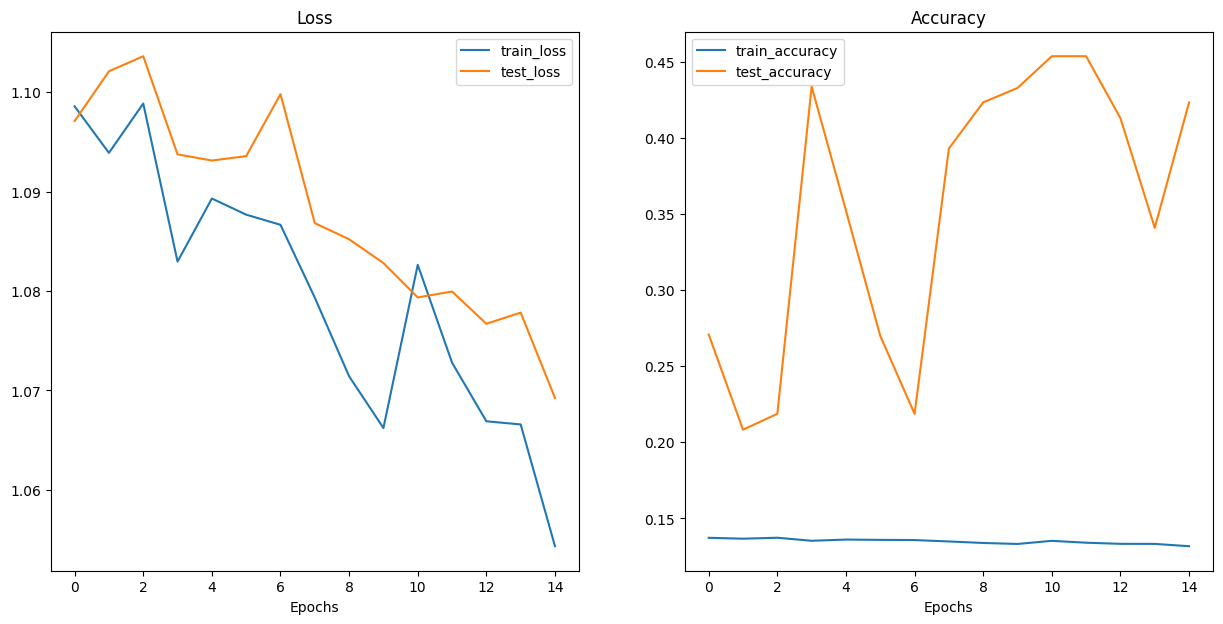

In [24]:

data1=CustomDataTest()
model0=TinnyVGG(3,len(data1.train_data_custom.classes),5)

model0_optimizer=torch.optim.Adam(params=model0.parameters(),lr=0.001)
model0_loss_fn=nn.CrossEntropyLoss()

start_time=timer()
model0_results=Totrain(model0,data=data1,epochs=15,optimizer=model0_optimizer,loss_fn=model0_loss_fn)

end_time=timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")
plot_loss_curves(model0_results)

Model with 

In [42]:
class TinnyVGGNorm2D(nn.Module):
    def __init__(self,in_shape:int,out_shape:int,hidden_units:int) -> None:
        super().__init__()

        self.conv_block1=nn.Sequential(
            nn.Conv2d(in_channels=in_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.InstanceNorm2d(num_features=hidden_units,eps=1e-5,momentum=0.1,affine=True),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.InstanceNorm2d(num_features=hidden_units,eps=1e-5,momentum=0.1,affine=True),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )
        self.classifier=nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*32*32,out_features=out_shape)
        )
        print(self.state_dict)
    def forward(self,x):
        return(self.classifier(self.conv_block1(x)))
    


<bound method Module.state_dict of TinnyVGGNorm2D(
  (conv_block1): Sequential(
    (0): Conv2d(3, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): InstanceNorm2d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (2): ReLU()
    (3): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): InstanceNorm2d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=5120, out_features=3, bias=True)
  )
)>


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:00<00:36,  1.33it/s]

Epoch: 1 | train_loss: 1.6315 | train_acc: 0.2039 | test_loss: 1.3941 | test_acc: 0.3438


  4%|▍         | 2/50 [00:01<00:35,  1.34it/s]

Epoch: 2 | train_loss: 1.3869 | train_acc: 0.1734 | test_loss: 1.4638 | test_acc: 0.3125


  6%|▌         | 3/50 [00:02<00:34,  1.36it/s]

Epoch: 3 | train_loss: 1.1726 | train_acc: 0.1466 | test_loss: 1.9779 | test_acc: 0.3229


  8%|▊         | 4/50 [00:02<00:33,  1.38it/s]

Epoch: 4 | train_loss: 1.3130 | train_acc: 0.1641 | test_loss: 0.9732 | test_acc: 0.5464


 10%|█         | 5/50 [00:03<00:32,  1.38it/s]

Epoch: 5 | train_loss: 0.8853 | train_acc: 0.1107 | test_loss: 1.4716 | test_acc: 0.3419


 12%|█▏        | 6/50 [00:04<00:31,  1.40it/s]

Epoch: 6 | train_loss: 0.9023 | train_acc: 0.1128 | test_loss: 1.0379 | test_acc: 0.5464


 14%|█▍        | 7/50 [00:05<00:30,  1.41it/s]

Epoch: 7 | train_loss: 0.7528 | train_acc: 0.0941 | test_loss: 1.2464 | test_acc: 0.4252


 16%|█▌        | 8/50 [00:05<00:29,  1.40it/s]

Epoch: 8 | train_loss: 0.8052 | train_acc: 0.1007 | test_loss: 1.0225 | test_acc: 0.5369


 18%|█▊        | 9/50 [00:06<00:29,  1.41it/s]

Epoch: 9 | train_loss: 0.6629 | train_acc: 0.0829 | test_loss: 1.0066 | test_acc: 0.5568


 20%|██        | 10/50 [00:07<00:28,  1.40it/s]

Epoch: 10 | train_loss: 0.6879 | train_acc: 0.0860 | test_loss: 1.3765 | test_acc: 0.3636


 22%|██▏       | 11/50 [00:07<00:27,  1.40it/s]

Epoch: 11 | train_loss: 1.0788 | train_acc: 0.1348 | test_loss: 1.1687 | test_acc: 0.4953


 24%|██▍       | 12/50 [00:08<00:27,  1.41it/s]

Epoch: 12 | train_loss: 0.6879 | train_acc: 0.0860 | test_loss: 1.3684 | test_acc: 0.3835


 26%|██▌       | 13/50 [00:09<00:26,  1.40it/s]

Epoch: 13 | train_loss: 0.8391 | train_acc: 0.1049 | test_loss: 1.3120 | test_acc: 0.5142


 28%|██▊       | 14/50 [00:10<00:25,  1.41it/s]

Epoch: 14 | train_loss: 0.8431 | train_acc: 0.1054 | test_loss: 1.7362 | test_acc: 0.3845


 30%|███       | 15/50 [00:10<00:24,  1.40it/s]

Epoch: 15 | train_loss: 0.7351 | train_acc: 0.0919 | test_loss: 1.1224 | test_acc: 0.5341


 32%|███▏      | 16/50 [00:11<00:24,  1.40it/s]

Epoch: 16 | train_loss: 0.8015 | train_acc: 0.1002 | test_loss: 1.6870 | test_acc: 0.3324


 34%|███▍      | 17/50 [00:12<00:23,  1.39it/s]

Epoch: 17 | train_loss: 0.7440 | train_acc: 0.0930 | test_loss: 1.0238 | test_acc: 0.5019


 36%|███▌      | 18/50 [00:12<00:23,  1.39it/s]

Epoch: 18 | train_loss: 0.7428 | train_acc: 0.0929 | test_loss: 1.6650 | test_acc: 0.3627


 38%|███▊      | 19/50 [00:13<00:22,  1.40it/s]

Epoch: 19 | train_loss: 0.6753 | train_acc: 0.0844 | test_loss: 1.1172 | test_acc: 0.5028


 40%|████      | 20/50 [00:14<00:21,  1.41it/s]

Epoch: 20 | train_loss: 0.6700 | train_acc: 0.0837 | test_loss: 1.8405 | test_acc: 0.3636


 42%|████▏     | 21/50 [00:15<00:20,  1.40it/s]

Epoch: 21 | train_loss: 0.8081 | train_acc: 0.1010 | test_loss: 1.1336 | test_acc: 0.4527


 44%|████▍     | 22/50 [00:15<00:20,  1.36it/s]

Epoch: 22 | train_loss: 0.7782 | train_acc: 0.0973 | test_loss: 1.3655 | test_acc: 0.3627


 46%|████▌     | 23/50 [00:16<00:19,  1.37it/s]

Epoch: 23 | train_loss: 0.6444 | train_acc: 0.0806 | test_loss: 1.2154 | test_acc: 0.5057


 48%|████▊     | 24/50 [00:17<00:19,  1.36it/s]

Epoch: 24 | train_loss: 0.8647 | train_acc: 0.1081 | test_loss: 1.3203 | test_acc: 0.4640


 50%|█████     | 25/50 [00:18<00:18,  1.35it/s]

Epoch: 25 | train_loss: 0.8748 | train_acc: 0.1094 | test_loss: 1.0644 | test_acc: 0.5966


 52%|█████▏    | 26/50 [00:18<00:17,  1.37it/s]

Epoch: 26 | train_loss: 0.6852 | train_acc: 0.0856 | test_loss: 1.1696 | test_acc: 0.5256


 54%|█████▍    | 27/50 [00:19<00:16,  1.39it/s]

Epoch: 27 | train_loss: 0.6406 | train_acc: 0.0801 | test_loss: 1.0852 | test_acc: 0.5455


 56%|█████▌    | 28/50 [00:20<00:15,  1.41it/s]

Epoch: 28 | train_loss: 0.7058 | train_acc: 0.0882 | test_loss: 1.2024 | test_acc: 0.5473


 58%|█████▊    | 29/50 [00:20<00:15,  1.39it/s]

Epoch: 29 | train_loss: 0.7744 | train_acc: 0.0968 | test_loss: 1.4020 | test_acc: 0.3930


 60%|██████    | 30/50 [00:21<00:14,  1.40it/s]

Epoch: 30 | train_loss: 0.8222 | train_acc: 0.1028 | test_loss: 1.2769 | test_acc: 0.4754


 62%|██████▏   | 31/50 [00:22<00:13,  1.40it/s]

Epoch: 31 | train_loss: 0.5967 | train_acc: 0.0746 | test_loss: 1.1829 | test_acc: 0.5663


 64%|██████▍   | 32/50 [00:23<00:12,  1.40it/s]

Epoch: 32 | train_loss: 0.7076 | train_acc: 0.0885 | test_loss: 1.5114 | test_acc: 0.3939


 66%|██████▌   | 33/50 [00:23<00:12,  1.39it/s]

Epoch: 33 | train_loss: 0.6306 | train_acc: 0.0788 | test_loss: 1.1532 | test_acc: 0.4612


 68%|██████▊   | 34/50 [00:24<00:11,  1.40it/s]

Epoch: 34 | train_loss: 0.7381 | train_acc: 0.0923 | test_loss: 1.7629 | test_acc: 0.4034


 70%|███████   | 35/50 [00:25<00:10,  1.40it/s]

Epoch: 35 | train_loss: 0.5493 | train_acc: 0.0687 | test_loss: 1.0591 | test_acc: 0.5331


 72%|███████▏  | 36/50 [00:25<00:10,  1.39it/s]

Epoch: 36 | train_loss: 0.4611 | train_acc: 0.0576 | test_loss: 1.3876 | test_acc: 0.4754


 74%|███████▍  | 37/50 [00:26<00:09,  1.41it/s]

Epoch: 37 | train_loss: 0.6111 | train_acc: 0.0764 | test_loss: 1.0018 | test_acc: 0.5966


 76%|███████▌  | 38/50 [00:27<00:08,  1.39it/s]

Epoch: 38 | train_loss: 0.5285 | train_acc: 0.0661 | test_loss: 1.1779 | test_acc: 0.5568


 78%|███████▊  | 39/50 [00:28<00:07,  1.39it/s]

Epoch: 39 | train_loss: 0.5605 | train_acc: 0.0701 | test_loss: 1.1579 | test_acc: 0.5057


 80%|████████  | 40/50 [00:28<00:07,  1.40it/s]

Epoch: 40 | train_loss: 0.3842 | train_acc: 0.0480 | test_loss: 1.0317 | test_acc: 0.6070


 82%|████████▏ | 41/50 [00:29<00:06,  1.38it/s]

Epoch: 41 | train_loss: 0.7847 | train_acc: 0.0981 | test_loss: 1.1909 | test_acc: 0.4934


 84%|████████▍ | 42/50 [00:30<00:05,  1.38it/s]

Epoch: 42 | train_loss: 1.0322 | train_acc: 0.1290 | test_loss: 1.1076 | test_acc: 0.5237


 86%|████████▌ | 43/50 [00:30<00:05,  1.37it/s]

Epoch: 43 | train_loss: 0.6310 | train_acc: 0.0789 | test_loss: 1.3343 | test_acc: 0.4953


 88%|████████▊ | 44/50 [00:31<00:04,  1.38it/s]

Epoch: 44 | train_loss: 0.5676 | train_acc: 0.0710 | test_loss: 1.4693 | test_acc: 0.4536


 90%|█████████ | 45/50 [00:32<00:03,  1.39it/s]

Epoch: 45 | train_loss: 0.5669 | train_acc: 0.0709 | test_loss: 1.0833 | test_acc: 0.5644


 92%|█████████▏| 46/50 [00:33<00:02,  1.37it/s]

Epoch: 46 | train_loss: 0.5569 | train_acc: 0.0696 | test_loss: 1.4095 | test_acc: 0.4659


 94%|█████████▍| 47/50 [00:33<00:02,  1.37it/s]

Epoch: 47 | train_loss: 0.4731 | train_acc: 0.0591 | test_loss: 1.2913 | test_acc: 0.5350


 96%|█████████▌| 48/50 [00:34<00:01,  1.37it/s]

Epoch: 48 | train_loss: 0.4701 | train_acc: 0.0588 | test_loss: 1.2942 | test_acc: 0.5265


 98%|█████████▊| 49/50 [00:35<00:00,  1.38it/s]

Epoch: 49 | train_loss: 0.3687 | train_acc: 0.0461 | test_loss: 1.4938 | test_acc: 0.4242


100%|██████████| 50/50 [00:35<00:00,  1.39it/s]

Epoch: 50 | train_loss: 0.6416 | train_acc: 0.0802 | test_loss: 1.1749 | test_acc: 0.4830
Total training time: 35.987 seconds


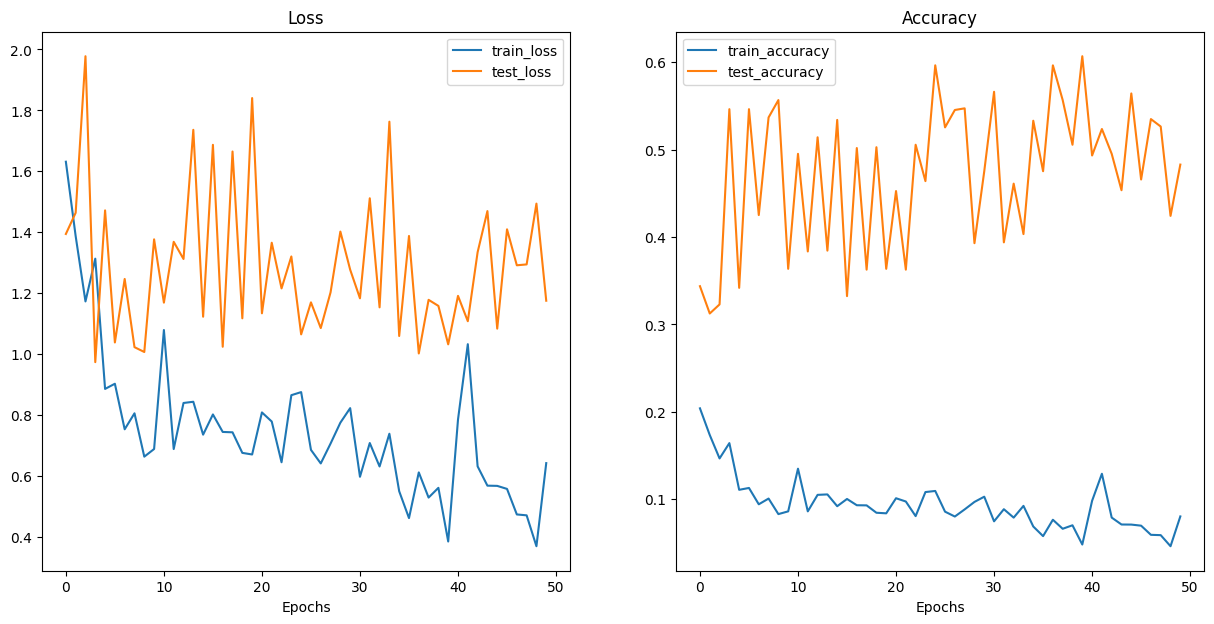

In [43]:
model1=TinnyVGGNorm2D(3,len(data1.train_data_custom.classes),5)

model1_optimizer=torch.optim.Adam(params=model1.parameters(),lr=0.001)
model1_loss_fn=nn.CrossEntropyLoss()

start_time=timer()
model1_results=Totrain(model1,data=data1,epochs=50,optimizer=model1_optimizer,loss_fn=model1_loss_fn)

end_time=timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")
plot_loss_curves(model1_results)

Testing usage of BlockDrop on TinnyVGG with InstanceNorm2d regularization 
BlockDrop class 

In [28]:

class BlockDrop(nn.Module):
    def __init__(self, block, p=0.5):
        super(BlockDrop, self).__init__()
        self.block = block
        self.p = p

    def forward(self, x):
        if self.training:
            return self.block(x) if torch.rand(1) > self.p else x
        return self.block(x)

class TinnyVGGBlockDrop(nn.Module):
    def __init__(self,in_shape:int,out_shape:int,hidden_units:int) -> None:
        super().__init__()

        self.conv_block1=BlockDrop(nn.Sequential(
            nn.Conv2d(in_channels=in_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.InstanceNorm2d(hidden_units),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.InstanceNorm2d(hidden_units),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)
        ))
        self.conv_block_2 = BlockDrop(nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.InstanceNorm2d(hidden_units),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.InstanceNorm2d(hidden_units),
            nn.ReLU(),
            nn.MaxPool2d(2)
        ))
        self.classifier=nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*16*16,out_features=out_shape)
        )
        print(self.state_dict)
    def forward(self,x):
        return(self.classifier(self.conv_block_2(self.conv_block1(x))))
    
    
   


In [ ]:
model2=TinnyVGGBlockDrop(3,len(data1.train_data_custom.classes),5)

model2_optimizer=torch.optim.Adam(params=model2.parameters(),lr=0.001)
model2_loss_fn=nn.CrossEntropyLoss()
start_time=timer()

model2_results=Totrain(model2,data=data1,epochs=50,optimizer=model2_optimizer,loss_fn=model2_loss_fn)

end_time=timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")
plot_loss_curves(model2_results)